In [161]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict, OrderedDict

import incense
from incense import ExperimentLoader
import pandas as pd
import os

import sys
sys.path.append('../')

from experiments import sacred_auth_details
from safe_exploration.environments.environments import InvertedPendulum

In [3]:
loader = ExperimentLoader(mongo_uri=sacred_auth_details.db_url, db_name='safe-exploration')

## Recent all experiments

In [ ]:
exps_by_time = loader.find({
    '$query':{
        '$or':[{'status': 'COMPLETED'}, {'status': 'RUNNING'}, {'status': 'FAILED'}]}, 
    '$orderby':{'start_time':-1}})
exps_by_time.project(on=['host.hostname', 'command', 'start_time', 'status', 'config.cem_ssm', 
                         'config.mpc_time_horizon', 
                         'config.mc_dropout_hidden_features'])[0:10]

## Recent main experiments

In [188]:
exps_by_time = loader.find({
    '$query':{
        '$or':[{'status': 'COMPLETED'}, {'status': 'RUNNING'}, {'status': 'FAILED'}],
        'command': 'main',
        '_id': {'$gt': 230}}, 
    '$orderby':{'start_time':-1}})
exps_by_time.project(on=['host.hostname', 'start_time', 'status', 'config.cem_ssm', 'config.exact_gp_kernel',
                         'config.junk_state_dimen', 'config.cem_beta_safety'])[:10]

,hostname,start_time,status,cem_ssm,exact_gp_kernel,junk_state_dimen,cem_beta_safety
exp_id,,,,,,,
296,oscar-2,2019-07-29 13:51:44.395,COMPLETED,exact_gp,nn,0,4.00
295,oscar-2,2019-07-29 13:34:54.190,COMPLETED,exact_gp,nn,0,3.75
294,oscar-2,2019-07-29 13:16:49.648,COMPLETED,exact_gp,nn,0,3.50
293,oscar-2,2019-07-29 13:02:13.420,COMPLETED,exact_gp,nn,0,3.25
291,oscar-2,2019-07-29 10:15:45.936,COMPLETED,exact_gp,nn,0,3.25
290,oscar-2,2019-07-29 09:41:27.097,FAILED,exact_gp,nn,0,3.25
289,oscar-2,2019-07-29 09:11:41.054,COMPLETED,exact_gp,nn,0,3.25
288,oscar-1,2019-07-28 21:00:25.447,COMPLETED,exact_gp,rbf,5,3.00
287,oscar-1,2019-07-28 19:48:29.046,COMPLETED,exact_gp,rbf,4,3.00


## Pendulum experiment details

In [183]:
exps = loader.find_by_ids([248, 293, 294, 295, 296, 252])

# Make sure all experiments have values for all config keys.
config_keys = set()
for exp in exps:
    config_keys.update(exp.config.keys())

for exp in exps:
    for key in config_keys:
        if key not in exp.config.keys():
            exp.config[key] = '?'
            
# Duplicate all metrics so we can use it multiple times in projections.
for exp in exps:
    exp.info['all_metrics2'] = exp.info.all_metrics

def failure_rate(metrics):
    all_lengths = list(itertools.chain.from_iterable(metrics['episode_length'].values()))
    total_steps = sum(all_lengths)
    failures = len(all_lengths) - all_lengths.count(50)
    percent = failures / total_steps * 100
    return f'{failures}/{total_steps} ({percent:.2f}%)'

def fallback_rate(metrics):
    total_steps = sum(itertools.chain.from_iterable(metrics['episode_length'].values()))
    fallback_steps = sum(itertools.chain.from_iterable(metrics['safe_controller_fallback_count'].values()))
    percent = fallback_steps / total_steps * 100
    return f'{fallback_steps}/{total_steps} ({percent:.2f}%)'

def landed(env_results):
    results = list(itertools.chain.from_iterable(env_results.values()))
    total = len(results)
    flying = results.count(0)
    crashed = results.count(1)
    landed = results.count(2)
    return f'{flying}/{crashed}/{landed} : {total}'

def mean(xs):
    print(xs)

frame = exps.project(on=['config.cem_ssm', 
                         'config.mc_dropout_type',
                         'config.cem_beta_safety',
                         'config.exact_gp_kernel',
                         'config.n_scenarios',
                         'config.junk_state_dimen',
                         {'info.all_metrics': failure_rate},
                         {'info.all_metrics2': fallback_rate},
                         {'metrics.sample_volume': max},
                         {'metrics.sample_variance': max},
                         {'metrics.mean_time_in_solver': np.mean}
#                          {'info.all_metrics.env_result': landed},
                        ])
# frame = frame.sort_values(['mc_dropout_hidden_features'])
frame.columns = map(lambda name: name.replace('mc_dropout', 'mcd'), frame.columns)
frame.columns = map(lambda name: name.replace('all_metrics', ''), frame.columns)
frame.columns = map(lambda name: name.replace('cem_beta_safety', 'beta'), frame.columns)

frame

,cem_ssm,mcd_type,beta,exact_gp_kernel,n_scenarios,junk_state_dimen,_failure_rate,2_fallback_rate,sample_volume_max,sample_variance_max,mean_time_in_solver_mean
exp_id,,,,,,,,,,,
248,exact_gp,concrete,3.00,nn,6,0,35/988 (3.54%),414/988 (41.90%),0.126658,0.022455,0.529790
293,exact_gp,concrete,3.25,nn,6,0,42/533 (7.88%),285/533 (53.47%),0.114303,0.018418,0.312313
294,exact_gp,concrete,3.50,nn,6,0,39/617 (6.32%),323/617 (52.35%),0.096941,0.017521,0.353070
295,exact_gp,concrete,3.75,nn,6,0,40/655 (6.11%),351/655 (53.59%),0.135637,0.023361,0.334395
296,exact_gp,concrete,4.00,nn,6,0,41/893 (4.59%),390/893 (43.67%),0.140712,0.027406,0.472998
252,exact_gp,concrete,4.50,nn,6,0,1/2379 (0.04%),2183/2379 (91.76%),0.061579,0.002327,0.688999


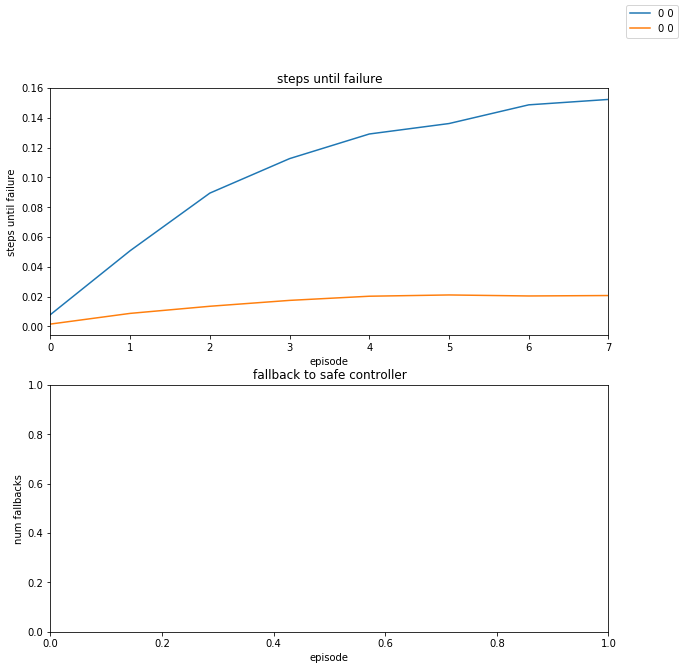

In [5]:
def get_label(exp):
    c = defaultdict(lambda: '?', exp.config)
    return f'{c["junk_state_dimen"]} {c["junk_action_dimen"]}'

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for exp in exps:
    label = get_label(exp)
    exp.metrics['sample_volume'].plot(ax=axes[0], label=label)
    exp.metrics['sample_variance'].plot(ax=axes[0], label=label)
#     exp.metrics['safe_controller_fallback_count'].plot(ax=axes[1], label='')
    
axes[0].set_ylabel('steps until failure')
axes[0].set_xlabel('episode')
axes[0].set_title('steps until failure')

axes[1].set_ylabel('num fallbacks')
axes[1].set_xlabel('episode')
axes[1].set_title('fallback to safe controller')

fig.legend()

## Plot failure rate and exploration

In [ ]:
def plot_failure_and_exploration(ids, get_name, x_label):
    exps = loader.find_by_ids(ids)
    x_ticks = {}
    xsl = []
    ysl = []
    stdl = []
    xsr = []
    ysr = []
    stdr = []

    def failure_rates(exp):
        lengths = np.empty((len(exp.info.all_metrics['episode_length']['json://0']), 
                            len(exp.info.all_metrics['episode_length'])))
        for ep, ep_data in enumerate(exp.info.all_metrics['episode_length'].values()):
            for s, s_data in enumerate(ep_data):
                lengths[s, ep] = s_data
        failures = np.count_nonzero(lengths != 50, axis=1)
        total_steps = lengths.sum(1)
        return failures / total_steps

    def exploration_volumes(exp):
        # Store the results in a matrix [scenario x episode]
        result = np.empty((len(exp.info.all_metrics['sample_volume']['json://0']), 
                           len(exp.info.all_metrics['sample_volume'])))
        for ep, ep_data in enumerate(exp.info.all_metrics['sample_volume'].values()):
            for s, s_data in enumerate(ep_data):
                result[s, ep] = s_data
        # Take max of all episodes in each scenario, which necessarily must be the last episode
        return result[:,-1]

    for i, exp in enumerate(exps):
        x_center = i + 1.
        x_ticks[x_center] = get_name(exp)
        failure = failure_rates(exp)
        exploration = exploration_volumes(exp)
        xsl.append(x_center - 0.1)
        ysl.append(failure.mean())
        stdl.append(failure.std())
        xsr.append(x_center + 0.1)
        ysr.append(exploration.mean())
        stdr.append(exploration.std())

    axl = plt.axes()
    axl.errorbar(xsl, ysl, yerr=stdl, fmt='o', color='C1', label='failure rate')
    axl.set_ylabel('failure rate')

    axr = axl.twinx()
    axr.errorbar(xsr, ysr, yerr=stdr, fmt='o', color='C2', label='exploration volume')
    axr.set_ylabel('exploration volume')

    axl.set_xticks(list(x_ticks.keys()))
    axl.set_xticklabels(list(x_ticks.values()))
    axl.set_xlabel(x_label)

    # plt.legend()

    plt.show()

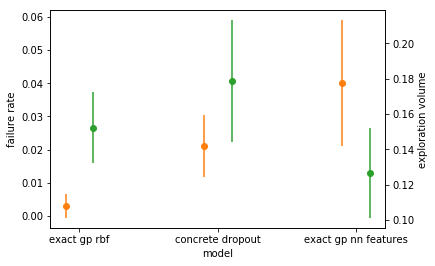

In [151]:
def get_model_name(exp):
    if exp.config['cem_ssm'] == 'exact_gp' and exp.config['exact_gp_kernel'] == 'rbf':
        return 'exact gp rbf'
    if exp.config['cem_ssm'] == 'exact_gp' and exp.config['exact_gp_kernel'] == 'nn':
        return 'exact gp nn features'
    if exp.config['cem_ssm'] == 'mc_dropout_gal':
        return 'concrete dropout'

    return 'unknown'
plot_failure_and_exploration([243, 263, 248], get_model_name, 'model')

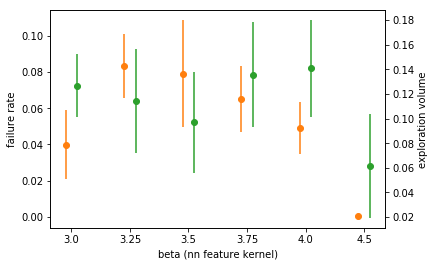

In [185]:
def get_name(exp):
    return exp.config['cem_beta_safety']
plot_failure_and_exploration([248, 293, 294, 295, 296, 252], get_name, 'beta (nn feature kernel)')

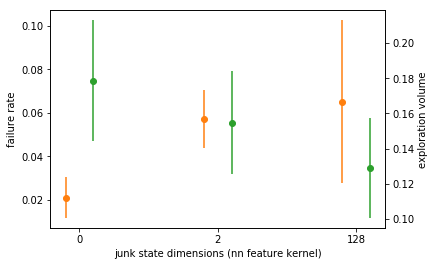

In [186]:
def get_name(exp):
    return exp.config['junk_state_dimen']
plot_failure_and_exploration([263, 267, 282], get_name, 'junk state dimensions (nn feature kernel)')

## Plot time in solver

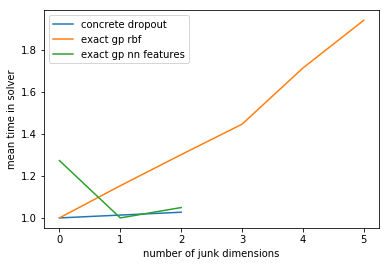

In [196]:
exps = loader.find_by_ids([263, 267, 282, 243, 244, 248, 249, 286, 287, 288, 259, 260])

def time_in_solver(exp):
    all_times = exp.info.all_metrics['mean_time_in_solver']
    times = np.empty((len(all_times['json://0']), len(all_times)))
    for ep, ep_data in enumerate(all_times.values()):
        for s, s_data in enumerate(ep_data):
            times[s, ep] = s_data
    return times.mean(1)

means = defaultdict(lambda: {})
stds = defaultdict(lambda: {})
for exp in exps:
    junk_dimen = exp.config['junk_state_dimen']
    
    if junk_dimen > 5:
        continue
    
    times = time_in_solver(exp)
    means[get_model_name(exp)][junk_dimen] = times.mean()
    stds[get_model_name(exp)][junk_dimen] = times.std()

for model in means.keys():
    means[model].items()
    min_mean = min(means[model].values())
    means_norm = {k: v/min_mean for k, v in means[model].items()}
    points = OrderedDict(sorted(means_norm.items()))    
    plt.plot(points.keys(), points.values(), label=model)
    
plt.legend()
plt.ylabel('mean time in solver')
plt.xlabel('number of junk dimensions')
plt.show()

## Plot samples

In [8]:
exp_id = 260
scenario = 4
total_ep = 7
episode = 6
exp = loader.find_by_id(exp_id)
artifacts = exp.artifacts

states = []

tmp_dir = '/tmp'

file_name = f'{exp_id}_initial_samples_{scenario}.npy'
artifacts[file_name].save(tmp_dir)
states.append(np.load(f'{tmp_dir}/{exp_id}_{file_name}')[:, :2])

for episode in range(total_ep):
    file_name = f'{exp_id}_states_actions_{scenario}_{episode}.npy'
    artifacts[file_name].save(tmp_dir)
    states.append(np.load(f'{tmp_dir}/{exp_id}_{file_name}')[:, :2])

env = InvertedPendulum(simple_constraints=exp.config['pendulum_simple_constraints'])
axes = plt.axes()
env.plot_states(axes, states, True)
plt.show()

KeyError: '260_initial_samples_4.npy'

## Failed episode dropout investigation

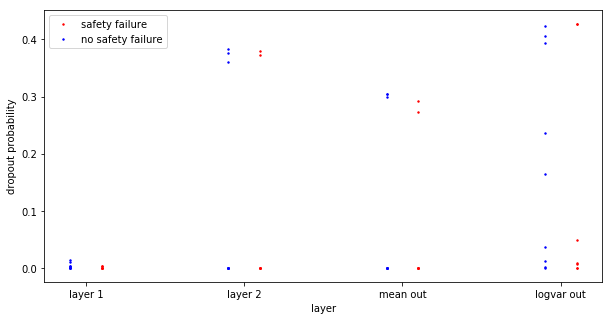

In [82]:
def map_name(name):
    if name == 'dropout_p_conc_drop1':
        return 'layer 1'
    if name == 'dropout_p_conc_drop2':
        return 'layer 2'
    if name == 'dropout_p_conc_drop_logvar':
        return 'logvar out'
    if name == 'dropout_p_conc_drop_mu':
        return 'mean out'
    return name

exp = loader.find_by_id(121)
dropout_metrics = {map_name(k): v for k,v in exp.info.all_metrics.items() if k.startswith('dropout_p')}
failed_episodes = [(1, 0), (1,1), (0,3), (0,5), (1,5), (0,6), (1,6)]

# Compare average p on non-failures, to value of p during failures

success_labels = []
success_data = []
failure_labels = []
failure_data = []

for metric_name, metric_data in dropout_metrics.items():
    for episode in range(len(metric_data)):
        episode_key = f'json://{episode}'
        for scenario in range(len(metric_data[episode_key])):
            if (scenario, episode) in failed_episodes:
                failure_labels.append(metric_name)
                failure_data.append(metric_data[episode_key][scenario])
            else:
                success_labels.append(metric_name)
                success_data.append(metric_data[episode_key][scenario])
                
label_vals = {
    'layer 1': 1.,
    'layer 2': 2.,
    'mean out': 3.,
    'logvar out': 4.
}
success_labels = [label_vals[label] - 0.1 for label in success_labels]
failure_labels = [label_vals[label] + 0.1 for label in failure_labels]

plt.figure(figsize=(10,5))
plt.scatter(failure_labels, failure_data, color='red', s=2, label='safety failure')
plt.scatter(success_labels, success_data, color='blue', s=2, label='no safety failure')
plt.xticks(list(label_vals.values()), list(label_vals.keys()))
plt.xlabel('layer')
plt.ylabel('dropout probability')
plt.legend()
plt.show()

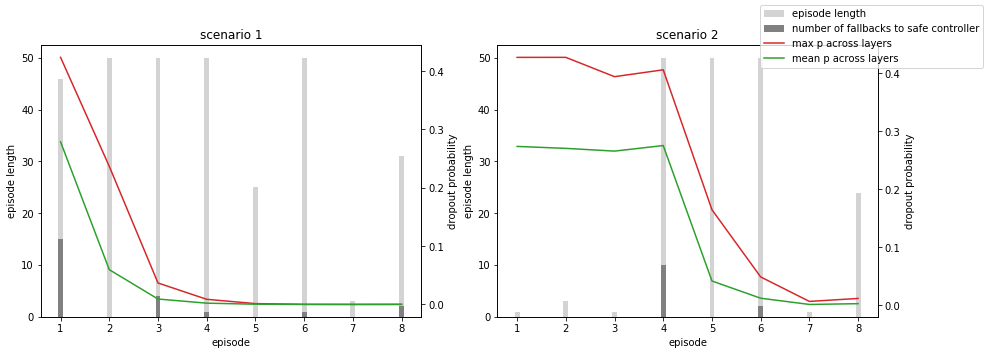

In [144]:
num_episodes = len(dropout_metrics['layer 1'])
num_scenarios = len(dropout_metrics['layer 1']['json://0'])
means = np.empty((num_scenarios, num_episodes))
maxes = np.empty((num_scenarios, num_episodes))
mins = np.empty((num_scenarios, num_episodes))
lengths = np.empty((num_scenarios, num_episodes))
fallbacks = np.empty((num_scenarios, num_episodes))
for episode in range(num_episodes):
    episode_key = f'json://{episode}'
    for scenario in range(num_scenarios):
        ps = [metric[episode_key][scenario] for metric in dropout_metrics.values()]
        mean = sum(ps) / len(ps)
        means[scenario, episode] = mean
        maxes[scenario, episode] = max(ps)
        mins[scenario, episode] = min(ps)
        
        lengths[scenario, episode] = exp.info.all_metrics.episode_length[episode_key][scenario]
        fallbacks[scenario, episode] = exp.info.all_metrics.safe_controller_fallback_count[episode_key][scenario]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
episodes = range(1, num_episodes + 1)

ax1.bar(episodes, lengths[0], width=0.1, color='lightgrey', label='episode length')
ax1.bar(episodes, fallbacks[0], width=0.1, color='grey', label='number of fallbacks to safe controller')
ax1.set_title('scenario 1')
ax1.set_ylabel('episode length')
ax1.set_xlabel('episode')
ax1b = ax1.twinx()
ax1b.plot(episodes, maxes[0], label='max p across layers', color='C3')
ax1b.plot(episodes, means[0], label='mean p across layers', color='C2')
ax1b.set_ylabel('dropout probability')

ax2.bar(episodes, lengths[1], width=0.1, color='lightgrey')
ax2.bar(episodes, fallbacks[1], width=0.1, color='grey')
ax2.set_title('scenario 2')
ax2.set_ylabel('episode length')
ax2.set_xlabel('episode')
ax2b = ax2.twinx()
ax2b.plot(episodes, maxes[1], label='', color='C3')
ax2b.plot(episodes, means[1], label='', color='C2')
ax2b.set_ylabel('dropout probability')
fig.legend()
plt.show()

## Failed experiments

In [41]:
exps_by_time = loader.find({
    '$query':{
        'status': 'FAILED',
        'command': 'main',
        '_id': {'$gt': 220}}, 
    '$orderby':{'start_time':-1}})
exps_by_time.project(on=['host.hostname', 'start_time', 'status', 'config.cem_ssm',  
                         'config.cem_beta_safety', 'config.exact_gp_kernel'])[0:30]

,hostname,start_time,status,cem_ssm,cem_beta_safety,exact_gp_kernel
exp_id,,,,,,
276,oscar-2,2019-07-26 23:24:44.030,FAILED,exact_gp,4.00,nn
275,oscar-2,2019-07-26 23:16:29.353,FAILED,exact_gp,3.75,nn
274,oscar-2,2019-07-26 22:54:13.550,FAILED,exact_gp,3.50,nn
273,oscar-2,2019-07-26 22:31:00.891,FAILED,exact_gp,3.25,nn
270,oscar-2,2019-07-26 19:40:40.865,FAILED,exact_gp,3.25,nn
266,oscar-2,2019-07-26 10:22:49.005,FAILED,exact_gp,3.75,nn
265,oscar-2,2019-07-26 10:15:50.281,FAILED,exact_gp,3.50,nn
264,oscar-2,2019-07-26 10:07:13.130,FAILED,exact_gp,3.25,nn
261,oscar-1,2019-07-26 01:17:21.001,FAILED,mc_dropout_gal,3.00,rbf


In [47]:
for line in loader.find_by_id(289).fail_trace:
    print(line)

AttributeError: 'EasyDict' object has no attribute 'fail_trace'

In [48]:
for line in loader.find_by_id(289).captured_out.split('\n'):
    if 'WARNING: found 0' in line:
        print(line)
    print(line)
print('done')

INFO - sacred_helper - Running command 'main'
INFO - sacred_helper - Started run with ID "289"
safempc_cem_InvertedPendulum_nsafe=1_nperf=0_r=1_beta_safety=2_0
 /home/oscar/safe-exploration/safe_exploration/environments/environments.py:463: UserWarning:Normalization turned off for now. Need to look into it
 /home/oscar/safe-exploration/safe_exploration/episode_runner.py:30: UserWarning:Need to check relative dynamics
 /home/oscar/safe-exploration/safe_exploration/utils_config.py:65: UserWarning:Normalization of constraints may be wrong!
Training GP on 10 data points for 1000 iterations...
Training complete. Final losses: -5.00 -5.01 -5.00 -5.01
Failed to detect content-type automatically for artifact /home/oscar/safe-exploration/experiments/safe_exploration_results/artifacts/289_initial_samples_0.npy.
Starting episode 1/8 in scenario 1/6
Using safe controller
total time solver in ms: 0.20816445350646973

===Old state unnormalized:
[-0.02281 -0.01701]
===Action unnormalized:
[0.03054]
=


===Old state unnormalized:
[-0.0001   0.00004]
===Action unnormalized:
[-0.00001]
===Next state unnormalized:
[-0.00009  0.00003]
Immediate cost for current step: [0]

==== Applied normalized action at time step 49 ====
[-0.00001]

==== Next state (normalized) ====
[-0.00009  0.00003]

Agent survived 50 steps
========== State/Action Trajectory ===========
[[ 0.02405  0.01973 -0.03461]
 [-0.00235  0.02028 -0.02646]
 [-0.0195   0.0197  -0.01991]
 [-0.02874  0.01847 -0.01514]
 [-0.03289  0.01691 -0.01165]
 [-0.03392  0.01522 -0.00904]
 [-0.03238  0.01356 -0.00732]
 [-0.02993  0.012   -0.00605]
 [-0.02745  0.01056 -0.00495]
 [-0.02456  0.00926 -0.00418]
 [-0.02176  0.0081  -0.00357]
 [-0.01926  0.00708 -0.00303]
 [-0.01682  0.00618 -0.00265]
 [-0.01479  0.00539 -0.00227]
 [-0.01289  0.0047  -0.00198]
 [-0.01131  0.0041  -0.0017 ]
 [-0.00984  0.00357 -0.00149]
 [-0.0086   0.00311 -0.00129]
 [-0.00747  0.00271 -0.00113]
 [-0.00649  0.00236 -0.00099]
 [-0.00567  0.00206 -0.00086]
 [-0.00498 


==== Next state (normalized) ====
[ 0.06647 -0.03788]

Using safe controller
total time solver in ms: 0.2096240520477295

===Old state unnormalized:
[ 0.06647 -0.03788]
===Action unnormalized:
[0.02853]
===Next state unnormalized:
[ 0.07098 -0.03441]
Immediate cost for current step: [0]

==== Applied normalized action at time step 3 ====
[0.02853]

==== Next state (normalized) ====
[ 0.07098 -0.03441]

Using safe controller
total time solver in ms: 0.21212983131408691

===Old state unnormalized:
[ 0.07098 -0.03441]
===Action unnormalized:
[0.02236]
===Next state unnormalized:
[ 0.06987 -0.03088]
Immediate cost for current step: [0]

==== Applied normalized action at time step 4 ====
[0.02236]

==== Next state (normalized) ====
[ 0.06987 -0.03088]

Using safe controller
total time solver in ms: 0.21178483963012695

===Old state unnormalized:
[ 0.06987 -0.03088]
===Action unnormalized:
[0.01799]
===Next state unnormalized:
[ 0.06525 -0.02752]
Immediate cost for current step: [0]

==== A

total time solver in ms: 0.30464935302734375

===Old state unnormalized:
[0.25105 0.03102]
===Action unnormalized:
[-0.12616]
===Next state unnormalized:
[0.11786 0.04019]
Immediate cost for current step: [0]

==== Applied normalized action at time step 29 ====
[-0.12616]

==== Next state (normalized) ====
[0.11786 0.04019]

Using safe controller
total time solver in ms: 0.3059823513031006

===Old state unnormalized:
[0.11786 0.04019]
===Action unnormalized:
[-0.09367]
===Next state unnormalized:
[0.02174 0.04344]
Immediate cost for current step: [0]

==== Applied normalized action at time step 30 ====
[-0.09367]

==== Next state (normalized) ====
[0.02174 0.04344]

Found solution
total time solver in ms: 0.30748629570007324

===Old state unnormalized:
[0.02174 0.04344]
===Action unnormalized:
[-0.20362]
===Next state unnormalized:
[-0.183    0.03994]
Immediate cost for current step: [0]

==== Applied normalized action at time step 31 ====
[-0.20362]

==== Next state (normalized) ====


[-0.09146]
===Next state unnormalized:
[ 0.25955 -0.01938]
Immediate cost for current step: [0]

==== Applied normalized action at time step 16 ====
[-0.09146]

==== Next state (normalized) ====
[ 0.25955 -0.01938]

Found solution
total time solver in ms: 0.27014684677124023

===Old state unnormalized:
[ 0.25955 -0.01938]
===Action unnormalized:
[-0.05624]
===Next state unnormalized:
[ 0.16225 -0.00905]
Immediate cost for current step: [0]

==== Applied normalized action at time step 17 ====
[-0.05624]

==== Next state (normalized) ====
[ 0.16225 -0.00905]

Found solution
total time solver in ms: 0.23285651206970215

===Old state unnormalized:
[ 0.16225 -0.00905]
===Action unnormalized:
[-0.59067]
===Next state unnormalized:
[-0.53399 -0.01616]
Immediate cost for current step: [0]

==== Applied normalized action at time step 18 ====
[-0.59067]

==== Next state (normalized) ====
[-0.53399 -0.01616]

Found solution
total time solver in ms: 0.2328639030456543

===Old state unnormalized:
[